In [27]:
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np 
import random
import seaborn as sns
import warnings
import time

import tensorflow as tf
from tensorflow.keras.layers import *
# Oversampling
from imblearn.over_sampling import RandomOverSampler
import sklearn
warnings.filterwarnings("ignore")

In [28]:
seed = 101
tf.random.set_seed(seed)
np.random.seed(seed)

In [29]:
df = pd.read_csv(r'dataset_fix2.csv', header=0)
df = df.drop(['no', 'bloodPressure'], axis=1)


In [30]:
df

,age,gender,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
0,76,P,20,88,36.0,1,1,1,0,1
1,68,p,23,70,36.0,1,1,1,0,1
2,62,p,20,83,36.8,1,1,0,0,1
3,54,L,22,88,37.0,1,0,0,0,1
4,83,L,18,82,36.8,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1550,63,P,20,95,35.5,1,0,0,0,0
1551,60,L,20,75,36.7,0,0,1,0,0
1552,50,L,18,80,36.8,0,0,1,0,0
1553,53,L,22,70,37.2,1,0,0,0,0


In [31]:
df.describe()

,age,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,52.829582,20.181994,77.218650,36.510611,0.362058,0.022508,0.158199,0.278457,0.099035
std,9.369569,1.748965,12.981317,0.903936,0.480750,0.148376,0.365045,0.448384,0.298806
min,32.000000,18.000000,50.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,19.000000,69.000000,35.700000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.000000,20.000000,75.000000,36.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,60.000000,21.000000,85.000000,37.300000,1.000000,0.000000,0.000000,1.000000,0.000000
max,92.000000,40.000000,155.000000,39.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Class Frequency\n0 : no stroke\n1: stroke')

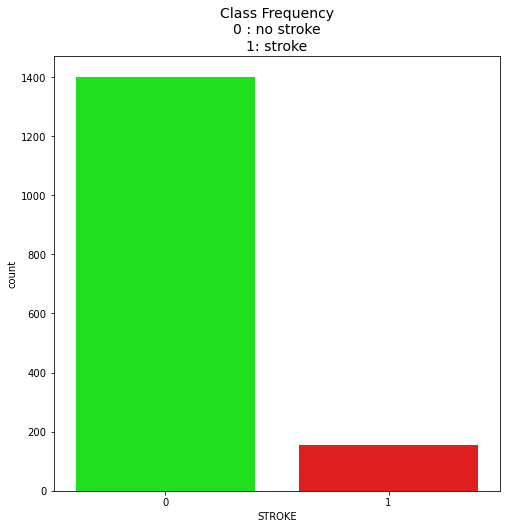

In [32]:
colors = ["#00FF00", "#FF0000"]
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot('STROKE', data=df, ax=ax, palette=colors)
plt.title('Class Frequency\n0 : no stroke\n1: stroke', fontsize=14)

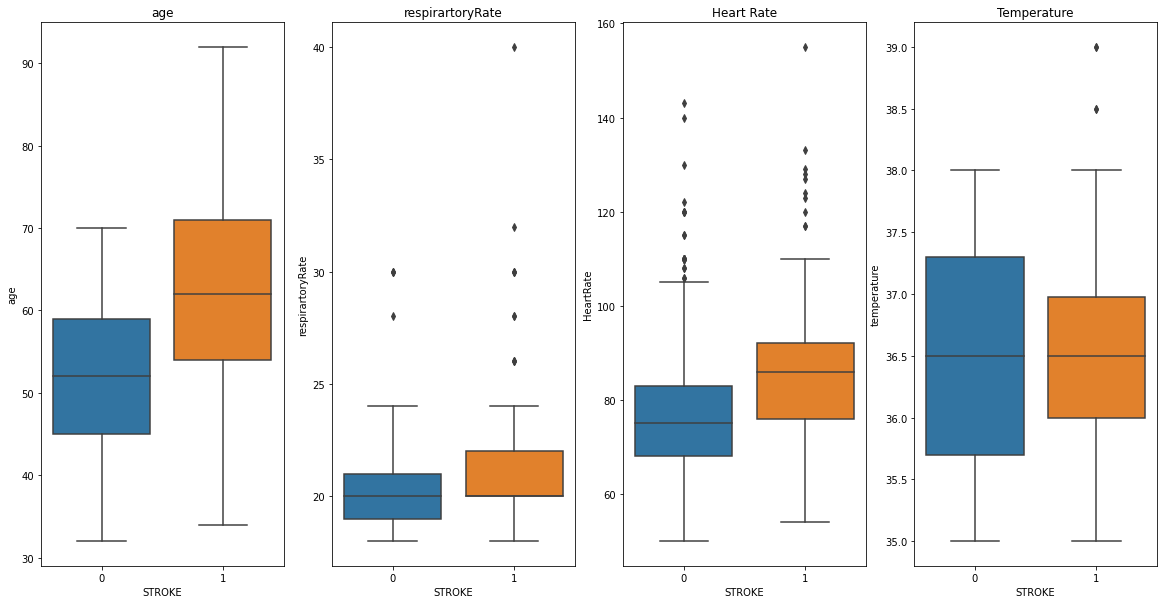

In [33]:
f, axes= plt.subplots(1, 4, figsize = (20, 10))
sns.boxplot(x="STROKE", y="age", data =df, ax=axes[0]).set_title('age')
sns.boxplot(x="STROKE", y="respirartoryRate", data =df, ax=axes[1]).set_title('respirartoryRate')
sns.boxplot(x="STROKE", y="HeartRate", data=df, ax=axes[2]).set_title('Heart Rate')
sns.boxplot(x="STROKE", y="temperature", data=df, ax=axes[3]).set_title('Temperature')
plt.show()

# Convert categorical values to numeric

In [34]:
gender = {'L': 0, 'l' : 0, 'P': 1, 'p' : 1}
df['gender'] = df['gender'].map(gender)

In [35]:
df.head()

,age,gender,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
0,76,1,20,88,36.0,1,1,1,0,1
1,68,1,23,70,36.0,1,1,1,0,1
2,62,1,20,83,36.8,1,1,0,0,1
3,54,0,22,88,37.0,1,0,0,0,1
4,83,0,18,82,36.8,1,0,0,1,1


In [36]:
X = df
y = X.pop('STROKE')

# Intialize Model

In [37]:
def baseline_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(len(X.columns),)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
    return model

In [38]:
model = baseline_model()

In [39]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_26 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________


In [40]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=seed)

In [41]:
y_pred = model.predict_classes(X_test)
report = sklearn.metrics.classification_report(y_test, y_pred.flatten())
print(report)

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       273
           1       0.00      0.00      0.00        38

    accuracy                           0.88       311
   macro avg       0.44      0.50      0.47       311
weighted avg       0.77      0.88      0.82       311



# Cross Validation

In [42]:
# Fit Model
EPOCHS = 30
BATCH_SIZE = 64

In [43]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

train_acc = []
test_acc = []
history = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train , y_train = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)
    model = baseline_model()
    history += [model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)]
    
    m = tf.keras.metrics.Accuracy()
    m.update_state(model.predict_classes(X_train), y_train)
    trainScore = m.result().numpy()

    m = tf.keras.metrics.Accuracy()
    m.update_state(model.predict_classes(X_test), y_test)
    testScore = m.result().numpy()

    train_acc.append(trainScore)
    test_acc.append(testScore)

y: 0.9068
Epoch 17/30
2242/2242 [==============================] - 0s 52us/sample - loss: 0.5934 - accuracy: 0.6632 - val_loss: 0.4871 - val_accuracy: 0.8328
Epoch 18/30
2242/2242 [==============================] - 0s 50us/sample - loss: 0.5039 - accuracy: 0.7467 - val_loss: 0.2462 - val_accuracy: 0.9164
Epoch 19/30
2242/2242 [==============================] - 0s 53us/sample - loss: 0.5850 - accuracy: 0.7132 - val_loss: 0.7990 - val_accuracy: 0.6367
Epoch 20/30
2242/2242 [==============================] - 0s 48us/sample - loss: 0.5650 - accuracy: 0.7079 - val_loss: 0.8741 - val_accuracy: 0.5402
Epoch 21/30
2242/2242 [==============================] - 0s 62us/sample - loss: 0.5181 - accuracy: 0.7337 - val_loss: 0.4140 - val_accuracy: 0.8103
Epoch 22/30
2242/2242 [==============================] - 0s 63us/sample - loss: 0.5045 - accuracy: 0.7435 - val_loss: 0.3595 - val_accuracy: 0.9100
Epoch 23/30
2242/2242 [==============================] - 0s 54us/sample - loss: 0.5068 - accuracy: 0.7

Text(0.5, 1.0, 'Class Frequency\n0 : no stroke\n1: stroke')

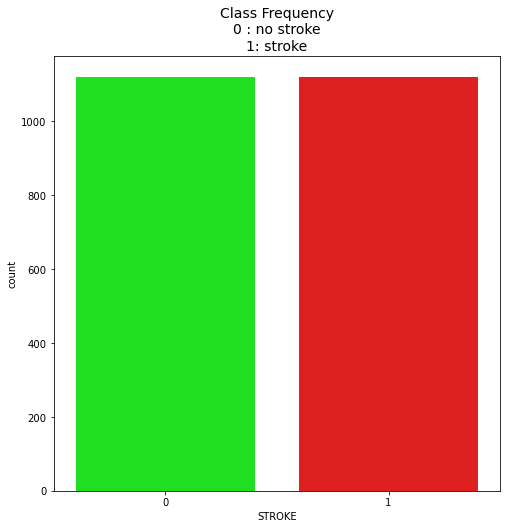

In [44]:
colors = ["#00FF00", "#FF0000"]
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot('STROKE', data=pd.concat([X_train,y_train], axis=1), ax=ax, palette=colors)
plt.title('Class Frequency\n0 : no stroke\n1: stroke', fontsize=14)

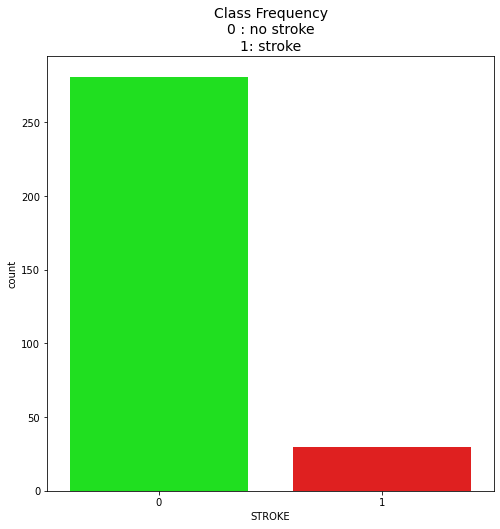

In [45]:
colors = ["#00FF00", "#FF0000"]
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot('STROKE', data=pd.concat([X_test,y_test], axis=1), ax=ax, palette=colors)
plt.title('Class Frequency\n0 : no stroke\n1: stroke', fontsize=14);

In [46]:
y_pred = model.predict_classes(X_test)
report = sklearn.metrics.classification_report(y_test, y_pred.flatten())
print(report)

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       281
           1       0.26      0.70      0.38        30

    accuracy                           0.78       311
   macro avg       0.61      0.75      0.62       311
weighted avg       0.89      0.78      0.82       311



In [47]:
train_acc

[0.75646746, 0.79036576, 0.7685103, 0.78902763, 0.7995536]

In [48]:
test_acc

[0.87138265, 0.7813505, 0.8874598, 0.8938907, 0.7813505]

In [49]:
loss_history = []
for history1 in history:
    loss_history += [history1.history['loss']]
acc_history = []
for history1 in history:
    acc_history += [history1.history['accuracy']]

loss_history_val = []
for history1 in history:
    loss_history_val += [history1.history['val_loss']]
acc_history_val = []
for history1 in history:
    acc_history_val += [history1.history['val_accuracy']]

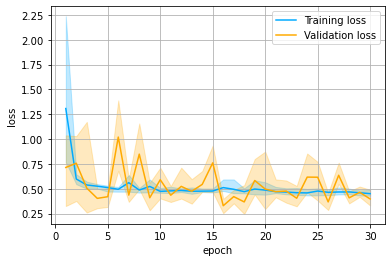

In [50]:
f, ax = plt.subplots()

ax.fill_between(range(1, EPOCHS+1), np.max(loss_history, axis=0), np.min(loss_history,axis=0) , alpha=0.25, color="#00aaff")
ax.fill_between(range(1, EPOCHS+1), np.max(loss_history_val, axis=0), np.min(loss_history_val,axis=0) , alpha=0.25, color="#ffaa00")

ax.plot(range(1, EPOCHS+1), np.average(loss_history, axis=0), color="#00aaff", label="Training loss")
ax.plot(range(1, EPOCHS+1), np.average(loss_history_val, axis=0), color="#ffaa00", label="Validation loss")

plt.ylabel('loss')
plt.xlabel('epoch')
ax.legend()
ax.grid(True)


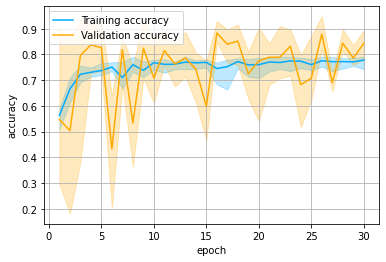

In [51]:
f, ax = plt.subplots()

ax.fill_between(range(1, EPOCHS+1), np.max(acc_history, axis=0), np.min(acc_history,axis=0) , alpha=0.25, color="#00aaff")
ax.fill_between(range(1, EPOCHS+1), np.max(acc_history_val, axis=0), np.min(acc_history_val,axis=0) , alpha=0.25, color="#ffaa00")

ax.plot(range(1, EPOCHS+1), np.average(acc_history, axis=0), color="#00aaff", label="Training accuracy")
ax.plot(range(1, EPOCHS+1), np.average(acc_history_val, axis=0), color="#ffaa00", label="Validation accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
ax.legend()
ax.grid(True)


In [65]:
# cross validation training accuracy
np.mean(train_acc)

0.7797114

In [66]:
# cross validation testing accuracy
np.mean(test_acc)

0.8327974

In [ ]:
X_test = X_test.reset_index().drop(['index'], axis=1)

## Predict individual sample

In [ ]:
index = 3 # or any other number

In [ ]:
test_sample = X_test.loc[index]
test_sample = np.array(test_sample).reshape(1, -1)

In [ ]:
test_sample

In [ ]:
model.predict(test_sample)

In [ ]:
y_test.reset_index().drop(['index'], axis=1).loc[index]

In [ ]:
#model.save_weights('sesuatu')

In [ ]:
from firebase import firebase
firebase = firebase.FirebaseApplication('https://stroke-25f59.firebaseio.com', None)

In [ ]:
riskfactors = firebase.get('/riskFactors', None)
vitalsigns = firebase.get('/vitalsigns', None)

In [ ]:
df = pd.DataFrame(riskfactors.values()).T
df.columns=riskfactors.keys()
df

In [ ]:
df['smoking'] = df['smoking'].astype(int)
df['dm'] = df['dm'].astype(int)
df['gender'] = df['gender'].astype(int)
df['heartDisease'] = df['heartDisease'].astype(int)
df['hypertension'] = df['hypertension'].astype(int)
df = df.drop('name', axis=1)

In [ ]:
df

In [ ]:
df2 = pd.DataFrame(vitalsigns.values()).T
df2.columns=vitalsigns.keys()
df2

In [ ]:
df = pd.concat([df,df2], axis=1)
df = df[['age', 'gender', 'respiratoryRate', 'heartRate', 'temperature', 'hypertension', 'dm', 'heartDisease', 'smoking']]


In [ ]:
df

## Predict from Db

In [ ]:
inputX = df.loc[0]
inputX = np.array(inputX, dtype=np.int).reshape(1, -1)

In [ ]:
inputX

In [ ]:
model.predict(inputX)

In [ ]:
model.predict(df)

In [ ]:
X.loc[0]

In [ ]:
df.loc[0]